# A fashionable use case : clothing classification with `fashion-mnist`

This activity was proposed by Professor Stephane Gaiffas during the MSc in Applied Mathematics at University of Paris in 2021. The instructions, as well as the code structure, was provided by Prof. Gaiffas.

- Load data with `fashion_mnist.load_data()`
- There is no validation set, only a train and test set.
- The labels correspond to the following things

| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

## Your job

- Try to understand the data, visualize it, like we did before with MNIST and noMNIST
- Create a neural network, using the ideas from before, that classify accurately the clothes on the test set
- You will need to build a validation set from the train set in order to tune hyperparameters

## We want to see the following things

- Some learning curves (training) and the accuracy obtained on the test set for the architecture you considered
- A discussion about the impact of the hyperparameters on the accuracy (size of the kernels, number of kernels, number of layers, etc.)
- A clear comparison between your solutions (a table, or plots comparing the results obtained with different hyper-parameters and different architectures)
- An explanation of what kind of clothes are hard to distinguish and why (some visual explanation)
- You'll get a good grade if you reach a good accuracy **and** if your notebook is clean, with clear graphs and explanations of what you did **and** if you did serious comparisons between different architectures
- You can do everything on your laptop, but it might be a good idea to use google `colab` (https://colab.research.google.com/) to get free access to a GPU
- You will send your notebook **containing** the results (**WE WON'T RUN YOUR NOTEBOOK**), namely with the graphs and results that you want to show, as a **unique** jupyter notebook file (`.ipynb` extension). We won't open any other supplementary file.

In [ ]:
#Import TF packages
import tensorflow
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D

#Import MNIST and Fashion MNIST datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

#Import useful packages
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Understanding the data

First, we describe the fashion-mnist dataset (see https://www.kaggle.com/datasets/zalando-research/fashionmnist for further details) and provide multiple charts aiming to better visualize the data. This part is highly inspired by the code provided by Prof. Gaiffas and explored during the practical classes of the Deep Learning course.

The dataset contains:

i) **Train images**: contains 60k images (matrices 28x28). This is our train set, which will be later divided into train & validation sets.

ii) **Test images**: contains 10k images (matrices 28x28). This is our test set.

iii) **Train labels**: contains 60k labels (from 0 to 9), indicating the clothing types of the train images. This array will be later divided into train & validation arrays.

iv) **Test labels**: contains 10k labels, indicating the clothing types of the test images.

In [ ]:
#Import data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
#Check dimensions
print('Dimensions of Train Images:', train_images.shape)
print('Dimensions of Test Images:', test_images.shape)
print('Dimensions of Train Labels:', train_labels.shape)
print('Dimensions of Test Labels:', test_labels.shape)

Dimensions of Train Images: (60000, 28, 28)
Dimensions of Test Images: (10000, 28, 28)
Dimensions of Train Labels: (60000,)
Dimensions of Test Labels: (10000,)


Below we reshape the previously created structures in order to match the tensor structures that are accepted by the TensorFlow (TF) framework.

In [ ]:
#Number of classes
num_classes = 10
#Input image dimensions
img_rows, img_cols = 28, 28

#Reshape data
if K.image_data_format() == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
    test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
    test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

print('x_train shape:', train_images.shape)
print('x_test shape:', test_images.shape)
print('y_train shape:', train_labels.shape)
print('y_test shape:', test_labels.shape)

print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


Note that the **label distribution is the same in the train and test sets**: both have 10% of each clothing type. In further steps, when we divide the train set in test and validation, we will maintain this distribution.  

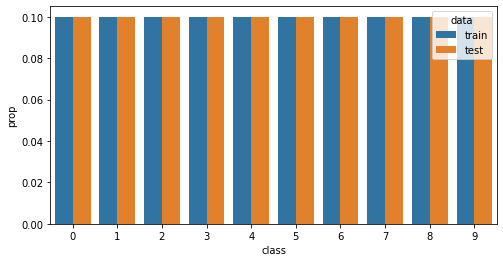

In [ ]:
#Verify the label distribution in the train and test sets
y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_labels) / train_labels.shape[0],
                         np.bincount(test_labels) / test_labels.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

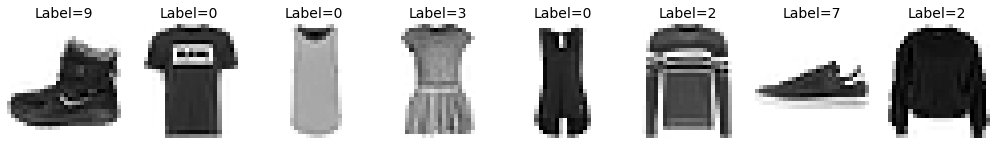

In [ ]:
#Print a few examples of images and their lables in the train set
plt.figure(figsize=(14, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(train_images[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % train_labels[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

**The following matrix represents the ankle boot shown in the chart above** (the first image). The positions of the matrix correspond to the pixels in the screen and numbers are related to the gray color intensity (zero correspond to white, 255 to black, and numbers in between are different gray shades).

In [ ]:
#Show the first image (the boot above) in a grayscale matrix
print(np.array2string(train_images[0].astype(np.int).reshape(28, 28),
                      max_line_width=150))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

# Preparing the data

Our data preparation encompasses two steps:

i) **Data normalization**: we convert the {0,..., 255} gray color scale to a [0,1] scale by dividing the color intensities in each image (matrix) by 255. As our Deep Learning methods involves multiple matrix multiplications, this normalization should help us to avoid overflows.

ii) **Convert labels to categories**: this become as a need imposed by what the TF framework is expecting.

In [ ]:
#Normalization of train and test datasets
train_images /= train_images.max()
test_images /= test_images.max()
print(train_images.min(axis=None), train_images.max(axis=None))

0.0 1.0


In [ ]:
#Convert label vectors to categories via one-hot encoding
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
train_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
#Check new shapes of the label structures
print(train_labels.shape)
print(test_labels.shape)

(60000, 10)
(10000, 10)


# Some useful plot functions

In [ ]:
def plot_history(history, method=''):
  """
    Plot the accuracy and loss per epoch.

    Args:
        history (model history): an object generated by the TF framework after applying the .fit method to a TF model.
        method (string): the name of the model to be displayed in the charts.

    Returns:
        charts: two line charts side-by-side: the accuracy and the loss per epoch.
    """

    #Plot two figures: accuracy evolution & loss evolution per epoch
    fig, axs = plt.subplots(1, 2, figsize=(14,5))

    #Plot accuracy per epoch
    axs[0].plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
    axs[0].plot(history.epoch, history.history['val_accuracy'], lw=3, label='Validation')
    axs[0].legend(fontsize=14)
    axs[0].set_title("Accuracy of "+method+" regression", fontsize=16)
    axs[0].set_xlabel('Epoch', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=14)

    #Plot loss per epoch
    axs[1].plot(history.epoch, history.history['loss'], lw=3, label='Training')
    axs[1].plot(history.epoch, history.history['val_loss'], lw=3, label='Validation')
    axs[1].legend(fontsize=14)
    axs[1].set_title("Loss of "+method+" regression", fontsize=16)
    axs[1].set_xlabel('Epoch', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=14)

    fig.tight_layout()

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix for the clothing types.
    Credits: Khoi Hoang (see References)

    Args:
        cm (metrics.confusion_matrix): a confusion matrix originated by the metrics.confusion_matrix method.
        names (list<string>): the list of the names of the clothing types

    Returns:
        chart: a confusion matrix with the clothing types in which color intensity replaces the numbers (facilitates visualization).
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Creating a validation set

We use the *train_test_split* method from Scikit Learn to **create a validation set with 30% of the train observations randomly chosen, maintaning the same distribution of clothing types in both sets** (train and validation).

In the end, the train set has 42k images and the validation set has 18k.

In [ ]:
#Create a validation set (from the train set)
from sklearn.model_selection import train_test_split

#Split train set in train and validation sets (keeping the same label distribution)
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.3, stratify=train_labels, random_state=12)

#Check labels distribution
print("Distribution of classes of train examples: ", train_labels.mean(axis=0))
print("Distribution of classes of validation examples: ", valid_labels.mean(axis=0))

#Check new shapes
print(train_labels.shape)
print(valid_labels.shape)

Distribution of classes of train examples:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Distribution of classes of validation examples:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
(42000, 10)
(18000, 10)


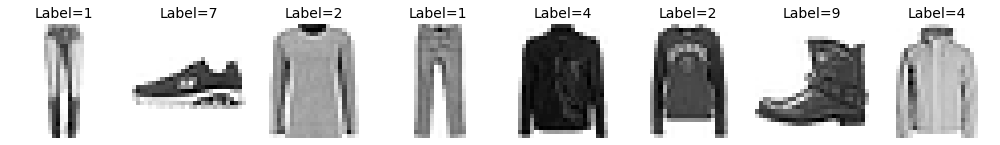

In [ ]:
#Print a few examples of images and their labels for new train set
plt.figure(figsize=(14, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(train_images[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % np.where(train_labels[i] == 1), fontsize=14)
    plt.axis("off")
plt.tight_layout()

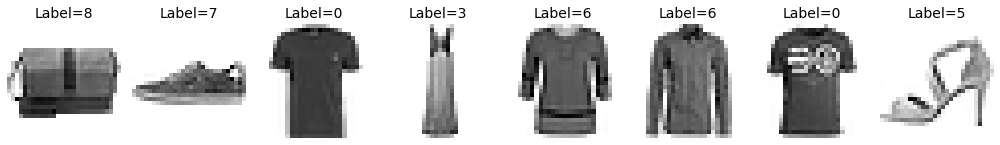

In [ ]:
#Print a few examples of images and their labels for new validation set
plt.figure(figsize=(14, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(valid_images[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % np.where(valid_labels[i] == 1), fontsize=14)
    plt.axis("off")
plt.tight_layout()

# Creating an execution method

In order to make the training simpler, we create a *run* function. It receives the model, the train, validation and test sets, the batch size, the number of epochs, and a verbose option. The function returns the accuracy/loss in the test set after having trained the model.

In [ ]:
def run_model(model, train_x, train_y, valid_x, valid_y, test_x, test_y, batch_size, epochs, verbose):
    """
    Train model and print main score-related statistics.

    Args:
        model (object supporting .fit method from TF): the model to be trained (see examples below)
        train/valid/test_x (TF tensor): the tensor representations of the images
        train/valid/test_y (TF tensor): the tensor representations of the labels
        batch_size (int): the batch size
        epochs (int): the number of epochs for training
        verbose (bool): an option for verbose

    Returns:
        history: the history output returned by the .fit method from TF
    """

  #Training
  history_model = model.fit(train_x, train_y,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=verbose,
                            validation_data=(valid_x, valid_y)
                            )

  #Evaluate the model on the test set
  score_model = model.evaluate(test_x, test_y, verbose=0)
  print('Test loss:', score_model[0])
  print('Test accuracy:', score_model[1])

  return history_model

# Our benchmark: a simple softmax regression

**We choose a softmax regression as our benchmark**. From now on, all of our methods will use the Adam optimizer (see discussion in further sections) and the cross-entropy as loss function.

Note that our images are represented by 28x28 matrices which are then transformed in vectors of $\mathbb{R}^{784}$ ($28 \times 28 = 784$) for the Softmax regression. As the number of classes is 10, the number of parameters $784 \times 10 + 10 = 7850$ (the last 10 parameters are related to the bias).

In [ ]:
#Benchmark: Softmax regression
model_softmax = Sequential()
model_softmax.add(Flatten(input_shape=input_shape, name='flatten'))
model_softmax.add(Dense(num_classes, activation='softmax', name='output'))

#Compile this model
model_softmax.compile(
    loss=losses.categorical_crossentropy,
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

model_softmax.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Our benchmark model is executed with a batch size of 128 for 500 epochs (with no early stopping). The **accuracy in the test set is ~83.4%** (with a loss of ~0.523).

In [ ]:
#Run Softmax regression
history_softmax = run_model(model_softmax,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = 128, epochs = 500, verbose = 0)

Test loss: 0.5227965116500854
Test accuracy: 0.8335999846458435


Note that the **precision is quite low for the labels 2 (Pullover), 4 (Coat) and 6 (Shirt)**, due to a high rate of false positives (i.e. we classified an image as a shirt, but it was not).

The **recall is also low for these clothing types**, showing a high presence of false negatives (i.e. many shirts in the DB are not classified as such).

In [ ]:
#Classification report
pred_labels = model_softmax.predict(test_images)
pred_labels = np.argmax(pred_labels, axis=1)

true_labels = np.argmax(test_labels, axis=1)

print(metrics.classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1000
           1       0.96      0.96      0.96      1000
           2       0.77      0.67      0.71      1000
           3       0.80      0.86      0.83      1000
           4       0.70      0.79      0.74      1000
           5       0.94      0.91      0.93      1000
           6       0.60      0.57      0.59      1000
           7       0.91      0.94      0.92      1000
           8       0.91      0.94      0.92      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



The confusion matrix below help us seeing that shirts are usually mistaken with T-shirts, pullovers and coats, for instance. Also, when we predict a shirt, it is often the case that the piece of clothing is in fact a T-shirt or a pullover.

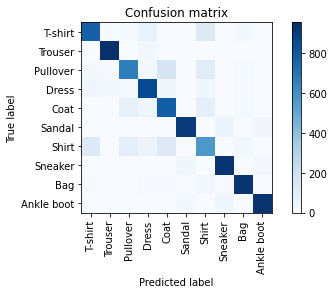

In [ ]:
#Graphic "confusion matrix"
cm = metrics.confusion_matrix(true_labels, pred_labels)

labelNames = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure()
plot_confusion_matrix(cm, labelNames)
plt.show()

# Discussing some hyperparameters on a simple FFNN model

Before we build and run more sophisticated architectures, **we implement a 1 hidden layer feed-forward neural network in order to discuss the following hyperparameters of the model**: (i) the number of epochs, (ii) the batch size, and (iii) the layer's width. We will also discuss the choice of the optimizer.

We choose *relu* as our activation function and start with a width of 500 for the layer.

Again, our image is flatten to a vector in $\mathbb{R}^{784}$. The first layer has $784 \times 500 + 500 = 392.500$ parameters, while the output layer has another $500 \times 10 + 10 = 5.010$ parameters to be estimated.

In [ ]:
# Define the model
model_ffnn = Sequential()
model_ffnn.add(Flatten(input_shape=input_shape, name='flatten'))
model_ffnn.add(Dense(500, activation='relu', name='dense'))
model_ffnn.add(Dense(num_classes, activation='softmax', name='output'))

#Compile this model
model_ffnn.compile(
    loss=losses.categorical_crossentropy,
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

model_ffnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
output (Dense)               (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


### Number of epochs

We run the architecture above for a large number of epochs (200). First, we verify that the model 'succeeds' in overfitting the test set. The validation loss decreases during the first ~25 epochs, and then starts rising.

Note that we reach an **accuracy of 89%** (loss of 0.99) after 200 epochs with this 1-layer FFNN, well above our benchmark. Hence, the simple introduction of a hidden layer helps us to gain ~6% of accuracy.

In [ ]:
#Run model
history_ffnn = run_model(model_ffnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = 128, epochs = 200, verbose = 1)

Epoch 1/200
329/329 [==============================] - 4s 11ms/step - loss: 0.5526 - accuracy: 0.8069 - val_loss: 0.4406 - val_accuracy: 0.8423
Epoch 2/200
329/329 [==============================] - 3s 10ms/step - loss: 0.3993 - accuracy: 0.8587 - val_loss: 0.3778 - val_accuracy: 0.8651
Epoch 3/200
329/329 [==============================] - 3s 10ms/step - loss: 0.3565 - accuracy: 0.8730 - val_loss: 0.3498 - val_accuracy: 0.8724
Epoch 4/200
329/329 [==============================] - 3s 10ms/step - loss: 0.3260 - accuracy: 0.8814 - val_loss: 0.3506 - val_accuracy: 0.8742
Epoch 5/200
329/329 [==============================] - 4s 11ms/step - loss: 0.3049 - accuracy: 0.8888 - val_loss: 0.3489 - val_accuracy: 0.8740
Epoch 6/200
329/329 [==============================] - 4s 13ms/step - loss: 0.2895 - accuracy: 0.8947 - val_loss: 0.3443 - val_accuracy: 0.8730
Epoch 7/200
329/329 [==============================] - 4s 11ms/step - loss: 0.2711 - accuracy: 0.9007 - val_loss: 0.3165 - val_accuracy:

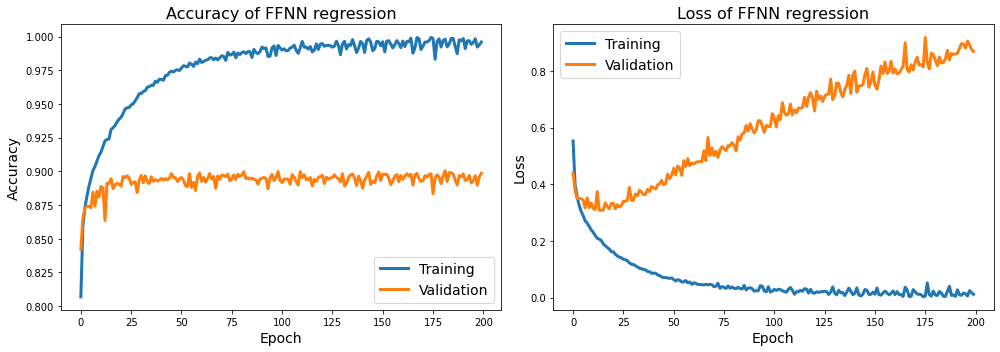

In [ ]:
plot_history(history_ffnn, method='FFNN')

### Batch size

We know that the batch size is an important parameter for the velocity of the optimizer. In this subsection, we run the same architecture as before but varying the batch size and we observe the execution time.

**We observe decreasing returns on batch size augmentation: increasing the batch size from 32 to 128 decreases execution time by a factor of 3, while from 512 to 2048, this factor is much smaller**.

In [ ]:
#Defining batch size parameters
b_size = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
ep = 10

#Running model for different batch sizes (for a fixed number of epochs)
for b_s in b_size:

  print('Batch size:', b_s)

  start = timer()
  history_ffnn = run_model(model_ffnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = b_s, epochs = ep, verbose = 0)
  end = timer()
  print('Execution time for', ep, 'epochs:', end-start, 'seconds \n')

Batch size: 16
Test loss: 1.0157368183135986
Test accuracy: 0.8801000118255615
Execution time for 10 epochs: 89.3667725330015 seconds 

Batch size: 32
Test loss: 1.1240257024765015
Test accuracy: 0.8816999793052673
Execution time for 10 epochs: 82.52386477300024 seconds 

Batch size: 64
Test loss: 1.1419626474380493
Test accuracy: 0.8822000026702881
Execution time for 10 epochs: 35.91646629600291 seconds 

Batch size: 128
Test loss: 1.1261789798736572
Test accuracy: 0.891700029373169
Execution time for 10 epochs: 27.937398206999205 seconds 

Batch size: 256
Test loss: 1.1774057149887085
Test accuracy: 0.8901000022888184
Execution time for 10 epochs: 22.313506335001875 seconds 

Batch size: 512
Test loss: 1.2112778425216675
Test accuracy: 0.8921999931335449
Execution time for 10 epochs: 21.11024472200006 seconds 

Batch size: 1024
Test loss: 1.2170438766479492
Test accuracy: 0.8932999968528748
Execution time for 10 epochs: 17.801462297997205 seconds 

Batch size: 2048
Test loss: 1.22755

### Layer's width

We run a similar analysis, but now varying the width of the sole layer of our architecture.

**We gain only 1% in accuracy multiplying by 16 the width of our layer (execution time multiplied by 12)** for 10 epochs. A  better idea may be keep the width smaller and increase the number of layers.

In [ ]:
#Define batch size and epochs
b_size = 128
ep = 10

#Define width parameters
width = [500, 1000, 2000, 4000, 8000]

#Running model for different width (for a fixed number of epochs)
for w in width:

  # Define the model
  model_ffnn = Sequential()
  model_ffnn.add(Flatten(input_shape=input_shape, name='flatten'))
  model_ffnn.add(Dense(w, activation='relu', name='dense'))
  model_ffnn.add(Dense(num_classes, activation='softmax', name='output'))

  #"Compile" this model
  model_ffnn.compile(
      loss=losses.categorical_crossentropy,
      optimizer=optimizers.Adagrad(),
      metrics=['accuracy']
  )

  print('Width:', w)

  start = timer()
  history_ffnn = run_model(model_ffnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = b_size, epochs = ep, verbose = 0)
  end = timer()
  print('Execution time for', w, 'width:', end-start, 'seconds \n')

Width: 500
Test loss: 0.6383411288261414
Test accuracy: 0.7903000116348267
Execution time for 500 width: 26.74348252299751 seconds 

Width: 1000
Test loss: 0.6242269277572632
Test accuracy: 0.7936000227928162
Execution time for 1000 width: 48.52506245300174 seconds 

Width: 2000
Test loss: 0.6066958904266357
Test accuracy: 0.7997000217437744
Execution time for 2000 width: 89.09356587900038 seconds 

Width: 4000
Test loss: 0.5973977446556091
Test accuracy: 0.8026999831199646
Execution time for 4000 width: 157.9000490929975 seconds 

Width: 8000
Test loss: 0.591346263885498
Test accuracy: 0.8077999949455261
Execution time for 8000 width: 319.06555541000125 seconds 



# Adding a new layer

Now, we add a second layer. Both layers are built with width 1k, with *relu* activation. We run 10 epochs again.

Note that **we gain ~0.5% of accuracy in the test set compared with the 1-layer 8k-width, with one-third of the time**.

Indeed, it seems that adding new layers is a better strategy than adding width.

In [ ]:
#Define batch size and epochs
b_size = 128
ep = 10

#Architecture with two layers
model_ffnn = Sequential()
model_ffnn.add(Flatten(input_shape=input_shape, name='flatten'))
model_ffnn.add(Dense(1000, activation='relu', name='dense1'))
model_ffnn.add(Dense(1000, activation='relu', name='dense2'))
model_ffnn.add(Dense(num_classes, activation='softmax', name='output'))

#"Compile" this model
model_ffnn.compile(
    loss=losses.categorical_crossentropy,
    optimizer=optimizers.Adagrad(),
    metrics=['accuracy']
)

#Running model
start = timer()
history_ffnn = run_model(model_ffnn,
                         train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                         batch_size = b_size, epochs = ep, verbose = 0)
end = timer()
print('Execution time for', end-start, 'seconds \n')

Test loss: 0.5664135217666626
Test accuracy: 0.8111000061035156
Execution time for 119.16519503399832 seconds 



## Choice of optimizer

We started running our methods with the Adagrad optimizer. However, we noted that the accuracy increase in each epoch was quite slow. Searching for new optimizers in the internet, we identified the following discussion on StackExchange (link: https://datascience.stackexchange.com/questions/10523/guidelines-for-selecting-an-optimizer-for-training-neural-networks)

*According to Kingma and Ba (2014) Adam has been developed for "large datasets and/or high-dimensional parameter spaces". The authors claim that: "[Adam] combines the advantages of [...] AdaGrad to deal with sparse gradients, and the ability of RMSProp to deal with non-stationary objectives" (page 9)*.

*In the paper, there are some simulations where Adam is compared to SGDNesterov, AdaGrad, RMSProp (MNIST, IMDB, page 6; CIFAR10 (ConvNet), page 7). Adam does very well compared to the others. The authors find that Adam converges faster than AdaGrad in a convolutional network (5x5 convolution filters, 3x3 max pooling with stride of 2 that are followed by a fully connected layer of 1000 rectified linear hidden units)*.

*Overall, Adam appears to be a good choice to start with for most (non-shallow) problems.*

**Running the 1-layer FFNN with Adagrad for the same 200 epochs (see discussion on the number of epochs), we reach a test accuracy of 85% (vs 89% with Adam)**. Empirically, we also note that we reach overfitting much faster with Adam. Therefore, we choose Adam as our optimizer.

Epoch 1/200
329/329 [==============================] - 4s 10ms/step - loss: 1.5251 - accuracy: 0.5653 - val_loss: 1.1660 - val_accuracy: 0.6765
Epoch 2/200
329/329 [==============================] - 3s 9ms/step - loss: 1.0270 - accuracy: 0.6993 - val_loss: 0.9404 - val_accuracy: 0.7135
Epoch 3/200
329/329 [==============================] - 3s 9ms/step - loss: 0.8775 - accuracy: 0.7319 - val_loss: 0.8395 - val_accuracy: 0.7408
Epoch 4/200
329/329 [==============================] - 3s 9ms/step - loss: 0.7997 - accuracy: 0.7548 - val_loss: 0.7789 - val_accuracy: 0.7602
Epoch 5/200
329/329 [==============================] - 3s 9ms/step - loss: 0.7489 - accuracy: 0.7679 - val_loss: 0.7374 - val_accuracy: 0.7668
Epoch 6/200
329/329 [==============================] - 3s 9ms/step - loss: 0.7120 - accuracy: 0.7781 - val_loss: 0.7041 - val_accuracy: 0.7769
Epoch 7/200
329/329 [==============================] - 3s 9ms/step - loss: 0.6836 - accuracy: 0.7864 - val_loss: 0.6792 - val_accuracy: 0.785

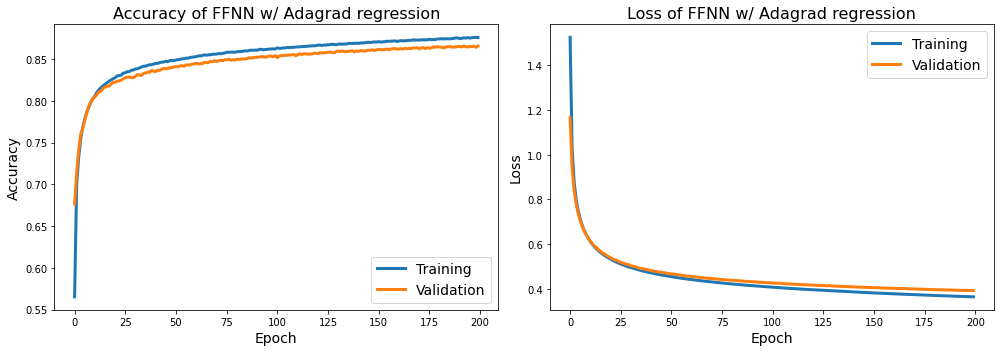

In [ ]:
#Define the model
model_ffnn = Sequential()
model_ffnn.add(Flatten(input_shape=input_shape, name='flatten'))
model_ffnn.add(Dense(500, activation='relu', name='dense'))
model_ffnn.add(Dense(num_classes, activation='softmax', name='output'))

#Compile this model with Adagrad optimizer
model_ffnn.compile(
    loss=losses.categorical_crossentropy,
    optimizer=optimizers.Adagrad(),
    metrics=['accuracy']
)

#Run model
history_ffnn = run_model(model_ffnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = 128, epochs = 200, verbose = 1)
#Plot history
plot_history(history_ffnn, method='FFNN w/ Adagrad')

# Adding Early Stopping to the training method

From now on, we set the batch size to 128 and the number of epochs will be defined by Early Stopping, with the parameters below.   

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

In [ ]:
def run_model(model, train_x, train_y, valid_x, valid_y, test_x, test_y, batch_size, epochs, verbose):
    """
    Train model (with early stopping) and print main score-related statistics.

    Args:
        model (object supporting .fit method from TF): the model to be trained (see examples below)
        train/valid/test_x (TF tensor): the tensor representations of the images
        train/valid/test_y (TF tensor): the tensor representations of the labels
        batch_size (int): the batch size
        epochs (int): the number of epochs for training
        verbose (bool): an option for verbose

    Returns:
        history: the history output returned by the .fit method from TF
    """

  #Run the train
  history_model = model.fit(train_x, train_y,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=verbose,
                            validation_data=(valid_x, valid_y),
                            callbacks=[early_stopping]
                            )

  #Evaluate the model on the test set
  score_model = model.evaluate(test_x, test_y, verbose=0)
  print('Test loss:', score_model[0])
  print('Test accuracy:', score_model[1])

  return history_model

# Proposing more sophisticated architectures

## Convolutional neural networks (CNN)

### Model 1: Simple CNN
- Convolutional layer with 64 filters and 3 * 3 kernel sizes and 'relu' activation
- Dense output layer with softmax activation

In [ ]:
#Architecture
model_cnn = Sequential()
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn.add(Flatten(name='flatten'))
model_cnn.add(Dense(num_classes, activation='softmax', name='output'))

#"Compile" model
model_cnn.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0         
_________________________________________________________________
output (Dense)               (None, 10)                432650    
Total params: 433,290
Trainable params: 433,290
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Run model
history_cnn = run_model(model_cnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
329/329 [==============================] - 24s 71ms/step - loss: 0.4734 - accuracy: 0.8350 - val_loss: 0.3546 - val_accuracy: 0.8743
Epoch 2/50
329/329 [==============================] - 23s 70ms/step - loss: 0.3143 - accuracy: 0.8889 - val_loss: 0.3141 - val_accuracy: 0.8887
Epoch 3/50
329/329 [==============================] - 23s 70ms/step - loss: 0.2711 - accuracy: 0.9044 - val_loss: 0.3009 - val_accuracy: 0.8938
Epoch 4/50
329/329 [==============================] - 23s 71ms/step - loss: 0.2460 - accuracy: 0.9121 - val_loss: 0.2968 - val_accuracy: 0.8943
Epoch 5/50
329/329 [==============================] - 23s 70ms/step - loss: 0.2238 - accuracy: 0.9210 - val_loss: 0.2920 - val_accuracy: 0.8991
Epoch 6/50
329/329 [==============================] - 23s 70ms/step - loss: 0.2084 - accuracy: 0.9246 - val_loss: 0.2858 - val_accuracy: 0.8997
Epoch 7/50
329/329 [==============================] - 23s 70ms/step - loss: 0.1916 - accuracy: 0.9319 - val_loss: 0.2872 - val_accuracy:

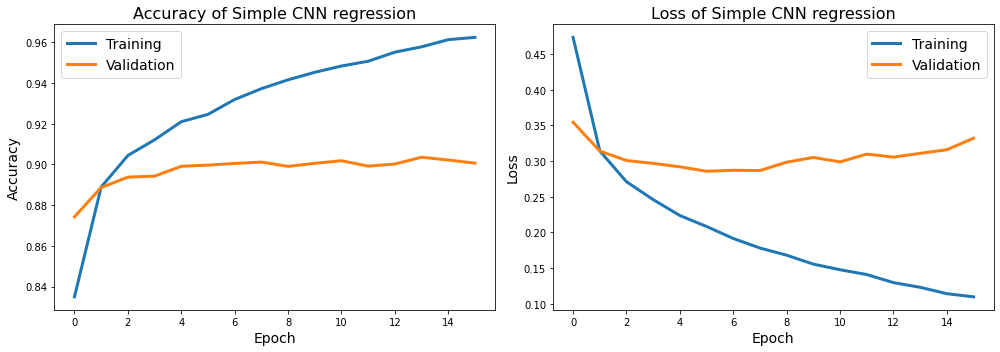

In [ ]:
plot_history(history_cnn, method='Simple CNN')

### Model 2: CNN with additional layers
- Convolutional layer with 64 filters and 3 * 3 kernel sizes and 'relu' activation
- Convolutional layer with 32 filters and 3 * 3 kernel sizes and 'relu' activation
- Dense layer with 128 units
- Dense output layer with softmax activation

In [ ]:
#Architecture
model_cnn = Sequential()
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'))
model_cnn.add(Flatten(name='flatten'))
model_cnn.add(Dense(128, activation='relu', name='dense'))
model_cnn.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 2,379,818
Trainable params: 2,379,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Run model
history_cnn = run_model(model_cnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
329/329 [==============================] - 138s 418ms/step - loss: 0.4655 - accuracy: 0.8348 - val_loss: 0.3277 - val_accuracy: 0.8826
Epoch 2/50
329/329 [==============================] - 139s 423ms/step - loss: 0.2944 - accuracy: 0.8940 - val_loss: 0.3213 - val_accuracy: 0.8812
Epoch 3/50
329/329 [==============================] - 139s 422ms/step - loss: 0.2338 - accuracy: 0.9144 - val_loss: 0.2703 - val_accuracy: 0.9019
Epoch 4/50
329/329 [==============================] - 137s 417ms/step - loss: 0.1879 - accuracy: 0.9306 - val_loss: 0.2703 - val_accuracy: 0.9090
Epoch 5/50
329/329 [==============================] - 138s 419ms/step - loss: 0.1510 - accuracy: 0.9447 - val_loss: 0.2841 - val_accuracy: 0.9044
Epoch 6/50
329/329 [==============================] - 138s 419ms/step - loss: 0.1159 - accuracy: 0.9592 - val_loss: 0.2852 - val_accuracy: 0.9098
Epoch 7/50
329/329 [==============================] - 139s 422ms/step - loss: 0.0874 - accuracy: 0.9675 - val_loss: 0.3256 -

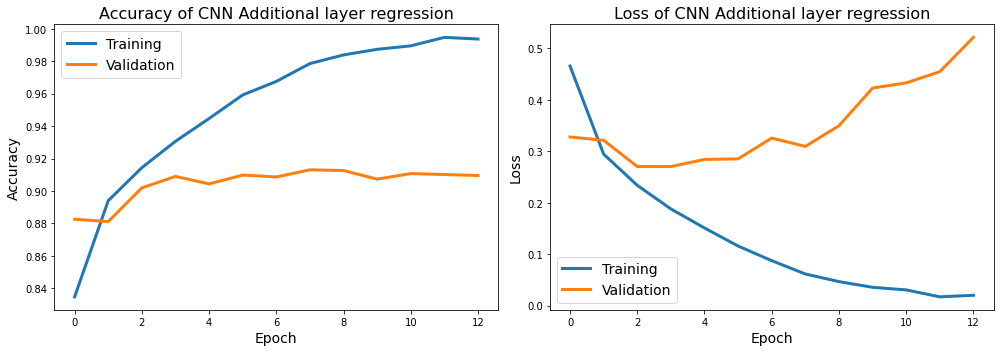

In [ ]:
plot_history(history_cnn, method='CNN Additional layer')

### Model 3: Gaiffas' CNN suggestion
- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 128 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 256 filters and 3 * 3 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Dense layer with 256 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

In [ ]:
#Architecture
model_cnn = Sequential()
model_cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1'))
model_cnn.add(Dropout(0.25, name='dropout_1'))
model_cnn.add(Conv2D(128, kernel_size=(5, 5), activation='relu', name='conv2d_2'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2'))
model_cnn.add(Dropout(0.25, name='dropout_2'))
model_cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_3'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_3'))
model_cnn.add(Dropout(0.25, name='dropout_3'))
model_cnn.add(Flatten(name='flatten'))
model_cnn.add(Dense(256, activation='relu', name='dense'))
model_cnn.add(Dropout(0.5, name='dropout_4'))
model_cnn.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)       

In [ ]:
#Run model
history_cnn = run_model(model_cnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
329/329 [==============================] - 170s 514ms/step - loss: 0.7729 - accuracy: 0.7102 - val_loss: 0.4524 - val_accuracy: 0.8308
Epoch 2/50
329/329 [==============================] - 171s 518ms/step - loss: 0.4548 - accuracy: 0.8364 - val_loss: 0.3618 - val_accuracy: 0.8665
Epoch 3/50
329/329 [==============================] - 170s 517ms/step - loss: 0.3775 - accuracy: 0.8639 - val_loss: 0.3165 - val_accuracy: 0.8855
Epoch 4/50
329/329 [==============================] - 169s 515ms/step - loss: 0.3418 - accuracy: 0.8755 - val_loss: 0.3176 - val_accuracy: 0.8813
Epoch 5/50
329/329 [==============================] - 169s 514ms/step - loss: 0.3160 - accuracy: 0.8848 - val_loss: 0.2890 - val_accuracy: 0.8938
Epoch 6/50
329/329 [==============================] - 159s 482ms/step - loss: 0.2987 - accuracy: 0.8916 - val_loss: 0.2844 - val_accuracy: 0.8945
Epoch 7/50
329/329 [==============================] - 157s 478ms/step - loss: 0.2840 - accuracy: 0.8965 - val_loss: 0.2746 -

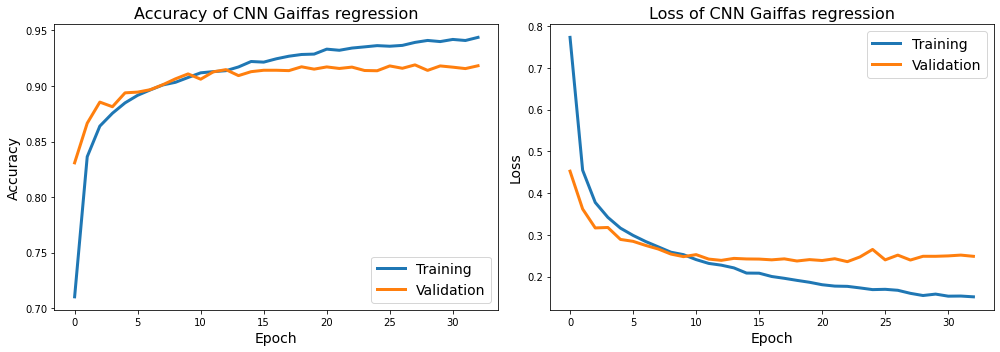

In [ ]:
plot_history(history_cnn, method='CNN Gaiffas')

# Model 4: Multi-layer CNN

Compared with previous models, our 'Multi-layer CNN' offers more Convolutional layers. **We obtain a test accuracy of 92.5%, the best mark among the implemented CNNs in this project**.

In [ ]:
#Architecture
model_cnn = Sequential()
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model_cnn.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
#Run model
history_cnn = run_model(model_cnn,
                            train_images, train_labels, valid_images, valid_labels, test_images, test_labels,
                            batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
329/329 [==============================] - 362s 1s/step - loss: 1.2277 - accuracy: 0.5587 - val_loss: 2.8231 - val_accuracy: 0.1783
Epoch 2/50
329/329 [==============================] - 364s 1s/step - loss: 0.6620 - accuracy: 0.7500 - val_loss: 0.5181 - val_accuracy: 0.7897
Epoch 3/50
329/329 [==============================] - 362s 1s/step - loss: 0.5597 - accuracy: 0.7924 - val_loss: 0.4447 - val_accuracy: 0.8353
Epoch 4/50
329/329 [==============================] - 363s 1s/step - loss: 0.4985 - accuracy: 0.8204 - val_loss: 0.5131 - val_accuracy: 0.8108
Epoch 5/50
329/329 [==============================] - 361s 1s/step - loss: 0.4466 - accuracy: 0.8432 - val_loss: 0.3864 - val_accuracy: 0.8629
Epoch 6/50
329/329 [==============================] - 361s 1s/step - loss: 0.4170 - accuracy: 0.8550 - val_loss: 0.4146 - val_accuracy: 0.8466
Epoch 7/50
329/329 [==============================] - 360s 1s/step - loss: 0.3922 - accuracy: 0.8630 - val_loss: 0.3182 - val_accuracy: 0.8856

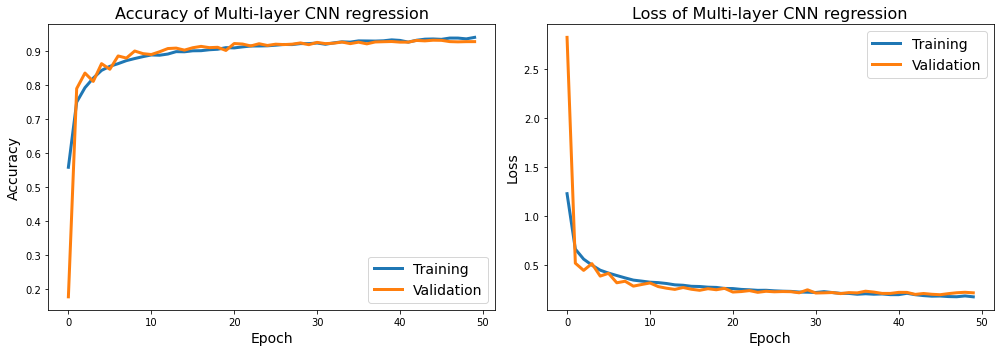

In [ ]:
plot_history(history_cnn, method='Multi-layer CNN')

# Best-in-class model and which clothes are hard to distinguish

In this section, we choose the Multi-layer CNN (Model 4) and plot its confusion matrix to see which clothing types are hard to distinguish.

The confusion matrix indicates that **shirts are the most difficult clothing item in terms of classification**, presenting the smallest precision (0.80) and recall (0.74).

In [ ]:
#Confusion matrix
pred_labels = model_cnn.predict(test_images)
pred_labels = np.argmax(pred_labels, axis=1)

true_labels = np.argmax(test_labels, axis=1)

print(metrics.classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.92      0.89      1000
           3       0.93      0.93      0.93      1000
           4       0.86      0.89      0.87      1000
           5       0.99      0.98      0.99      1000
           6       0.80      0.74      0.77      1000
           7       0.97      0.97      0.97      1000
           8       0.96      0.99      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



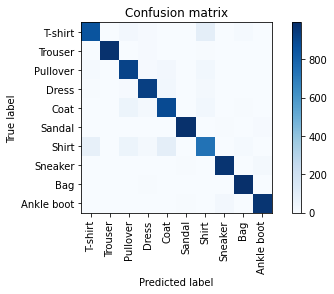

In [ ]:
#Confusion matrix
cm = metrics.confusion_matrix(true_labels, pred_labels)

labelNames = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure()
plot_confusion_matrix(cm, labelNames)
plt.show()

We see that **shirts (label 6) are usually mistaken with T-shirts (label 0), pullovers (label 2), and coats (label 4)**. We display below a few images of misclassified items. Indeed, the formats are so similar that even humans could misclassify some of them. Check, for instance, the first image of the last row. In my view, it is quite natural to mistake it for a shirt.

However, there are some unreasonable errors too. Check, for instance, the first image of the first row, where the boot is classified as a sandal.

In [ ]:
#Array with true labels
true_labels = np.argmax(test_labels, axis=1)

#Indicator of misclassified items
misclassif = pred_labels != true_labels

#Array with misclassified items' positions
misclassif_pos = []
for i in np.arange(len(misclassif)):
  if misclassif[i]:
    misclassif_pos.append(i)

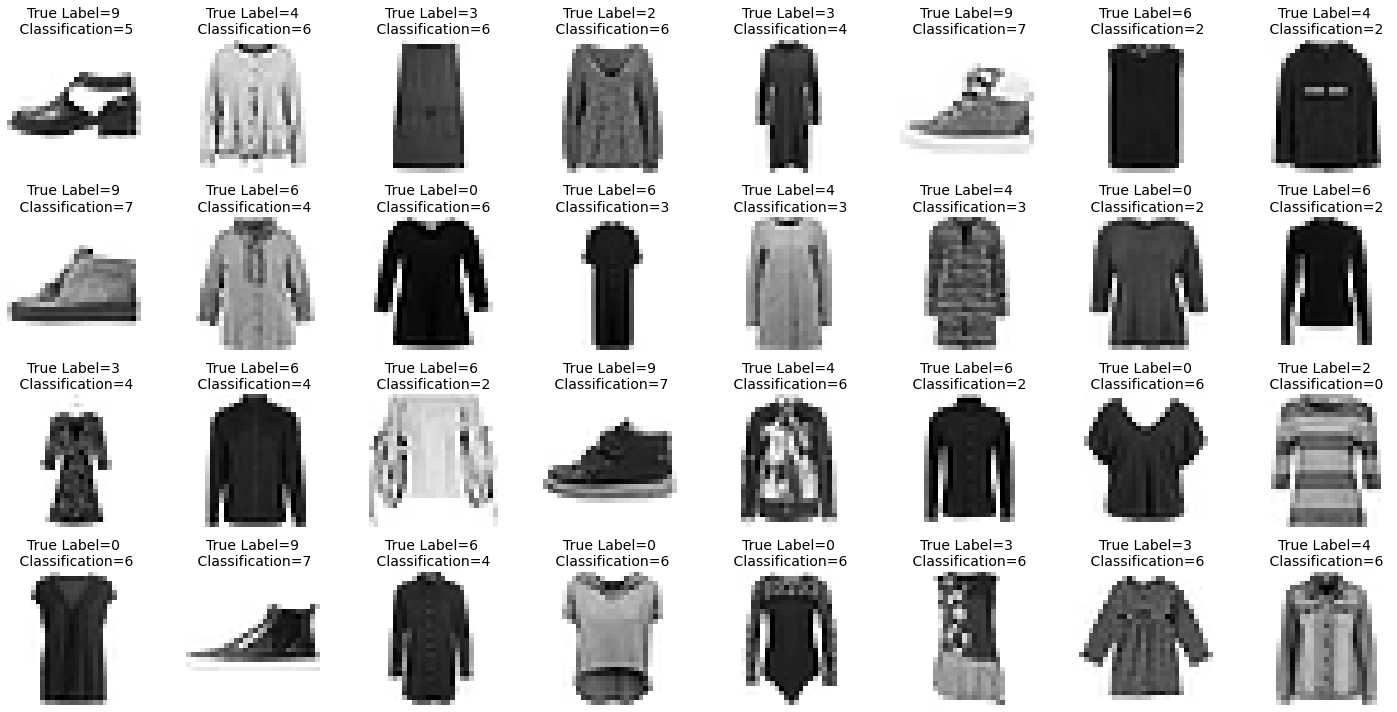

In [ ]:
#Print a few examples of misclassified labels
n_rows = 4
n_cols = 8
plt.figure(figsize=(20, 10))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(test_images[misclassif_pos[i]].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.title('True Label=%d' % true_labels[misclassif_pos[i]]+
              '\n Classification=%d' % pred_labels[misclassif_pos[i]], fontsize=14)
    plt.axis("off")
plt.tight_layout()

# Things to think about

This introductory activity introduces us to two major challenges when working with neural networks:

1. **How to come up with new architectures?** What are the best practices to build NNs?

2. **Once you have a reasonable architecture, how to choose what to change in order to obtain even better results?** In CNNs, for instance, do we add new convolutional layers? Do we decrease dropouts? Do we decrease the dimension of filters?  

# References

Notebook 11. *Multiple codes adapted for visualization of the dataset*. Stephane Gaiffas. Website: https://stephanegaiffas.github.io/teaching/m2mo.

CSC Final Project. Koi Hoang. Website: http://athena.ecs.csus.edu/~hoangkh/Image%20Classification%20with%20Fashion-MNIST%20and%20CIFAR-10.html . *We used Hoang's function for plotting the confusion matrix and also one of his architectures*.